# Testing MPI version for Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [2]:
from mpi4py import MPI
print(MPI.COMM_WORLD.size)



1


In [6]:

%matplotlib inline



import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path
results_dir = arl_path('test_results')


from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from processing_components.image.iterators import image_raster_iter

from processing_components.visibility.base import create_visibility
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.operations import show_image, export_image_to_fits
from processing_components.image.deconvolution import deconvolve_cube, restore_cube
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.simulation.testing_support import create_test_image
from processing_components.simulation.configurations import create_named_configuration
from processing_components.imaging.base import create_image_from_visibility
from workflows.mpi.imaging.imaging_mpi import predict_list_mpi_workflow, invert_list_mpi_workflow, deconvolve_list_mpi_workflow,weight_list_mpi_workflow

from data_models.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

In [7]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [8]:
lowcore = create_named_configuration('LOWBD2', rmax=400.0)

create_configuration_from_file: Maximum radius 400.0 m includes 146 antennas/stations


In [9]:
print(lowcore.xyz)

[[-1697.451395    1786.90252634 -4220.53729446]
 [-1899.245706    1676.22129979 -4000.47217072]
 [-1749.332463    1743.04062531 -4133.32761149]
 [-1980.112908    1741.06827262 -4129.40602467]
 [-1797.563795    1711.65424735 -4070.92274514]
 [-1856.918727    1634.47055507 -3917.46005486]
 [-1854.091115    1685.47915605 -4018.87936901]
 [-1841.933631    1735.45400747 -4118.24330093]
 [-1710.69259     1686.89797425 -4021.70037499]
 [-1998.747741    1692.42716624 -4032.69394958]
 [-1942.270247    1691.73930513 -4031.32629   ]
 [-1654.987395    1654.73474441 -3957.75091061]
 [-1834.982938    1762.89064318 -4172.79497894]
 [-1792.469112    1750.71903274 -4148.59442532]
 [-1882.541622    1709.46473429 -4066.569383  ]
 [-2062.126102    1714.44766716 -4076.47684221]
 [-1789.25535     1675.75003965 -3999.53517422]
 [-1660.667531    1684.05418174 -4016.04612295]
 [-1885.643275    1739.10263634 -4125.49779196]
 [-1776.101351    1727.22766226 -4101.88703409]
 [-1650.104471    1708.87873739 -4065.40

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [10]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))
print(vt)

create_visibility: 10585 rows, 0.001 GB
Visibility:
	Number of visibilities: 10585
	Number of channels: 1
	Frequency: [1.e+08]
	Number of polarisations: 1
	Visibility shape: (10585, 1)
	Polarisation Frame: stokesI
	Phasecentre: <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>
	Configuration: LOWBD2



Plot the synthesized uv coverage.

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


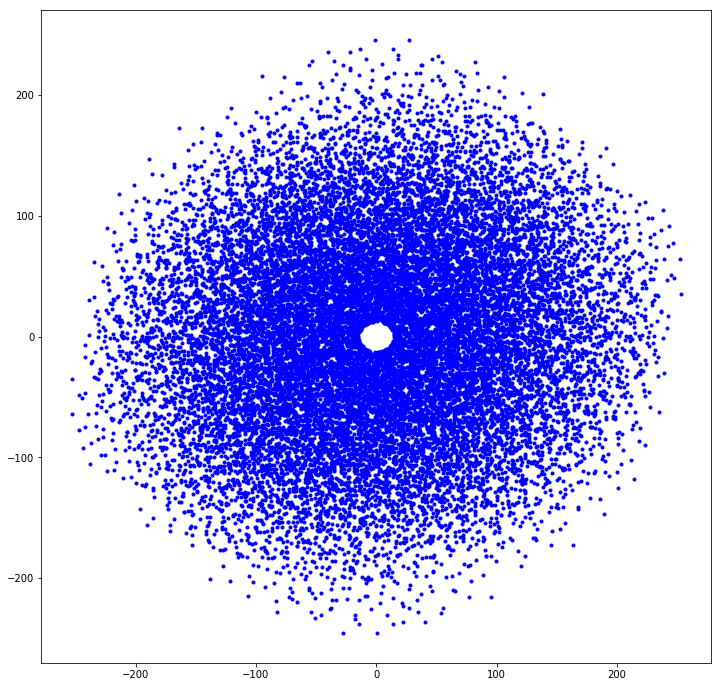

In [11]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
plt.show()

Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/montsefarreras/Documents/repo/tmp/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)
My image:
Image:
	Shape: (1, 1, 256, 256)
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 15.0  -45.0  1.0  100000000.0  
CRPIX : 128.0  128.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.02864788975654116  0.02864788975654116  1.0  100000.0  
NAXIS : 0  0
	Polarisation frame: stokesI

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
findfont: Matching :family=

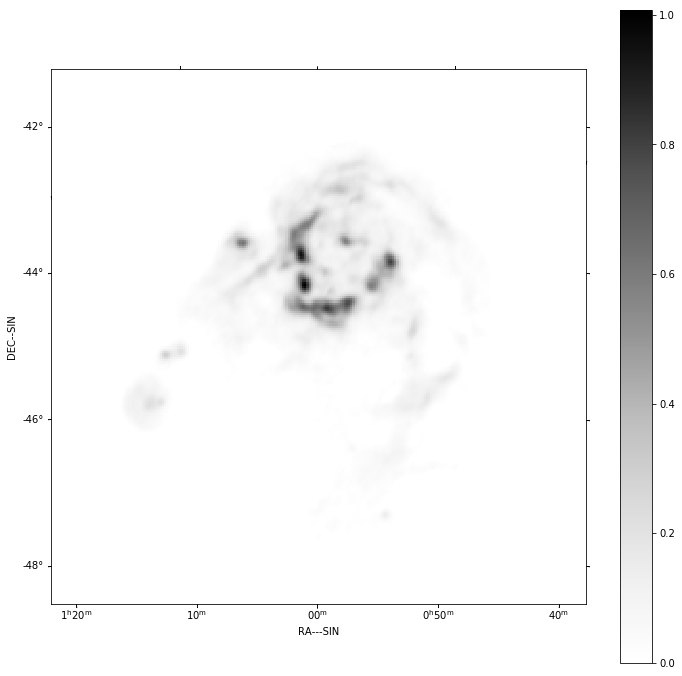

In [12]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)
print("My image:")
print(m31image)
print(m31image.data)
#print(m31image.wcs)
#print(m31image.polarisation_frame)
sumwt = numpy.zeros([m31image.nchan, m31image.npol])
fig=show_image(m31image)

In [13]:
vt = predict_list_mpi_workflow([vt], [m31image], context='2d',use_serial_predict=True)
print(vt)


0: In predict_list_mpi_workflow: 1 elements in vis_list
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.95950601, -44.97134495)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>


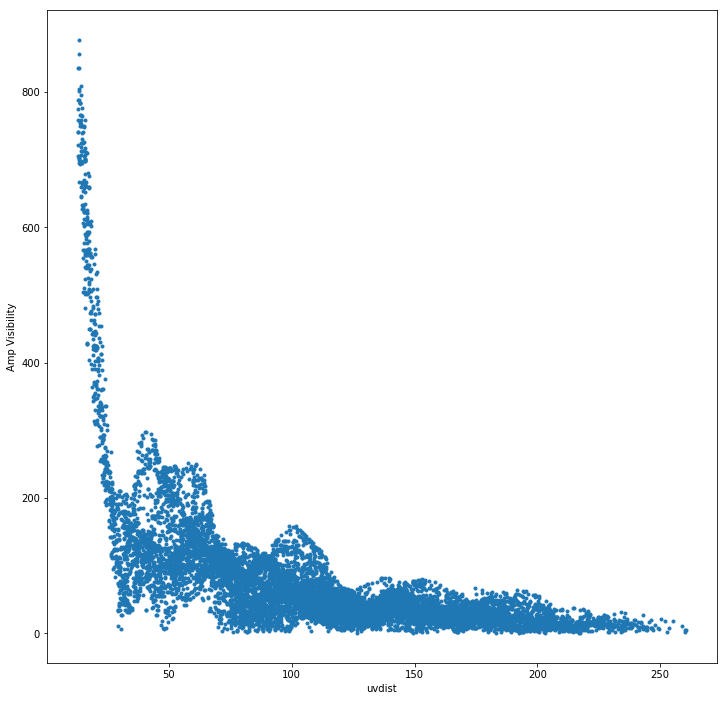

In [14]:
# To check that we got the prediction right, plot the amplitude of the visibility.
vt=vt[0]
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 253.011682 wavelengths
create_image_from_visibility: Critical cellsize = 0.001976 radians, 0.113228 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
0: In invert_list_mpi_workflow: 1 elements in vis_list 1 in model
[(<data_models.memory_data_models.Image object at 0x105569550>, array([[10585.]]))]
0: In invert_list_mpi_workflow: 1 elements in vis_list 1 in model
[(<data_models.memory_data_models.Image object at 0x11910e860>, array([[10585.]]))]
Max, min in dirty image = 33.418636, -7.539496, sumwt = 10585.000000
Max, min in PSF         = 0.999209, -0.024851, sumwt = 10585.000000


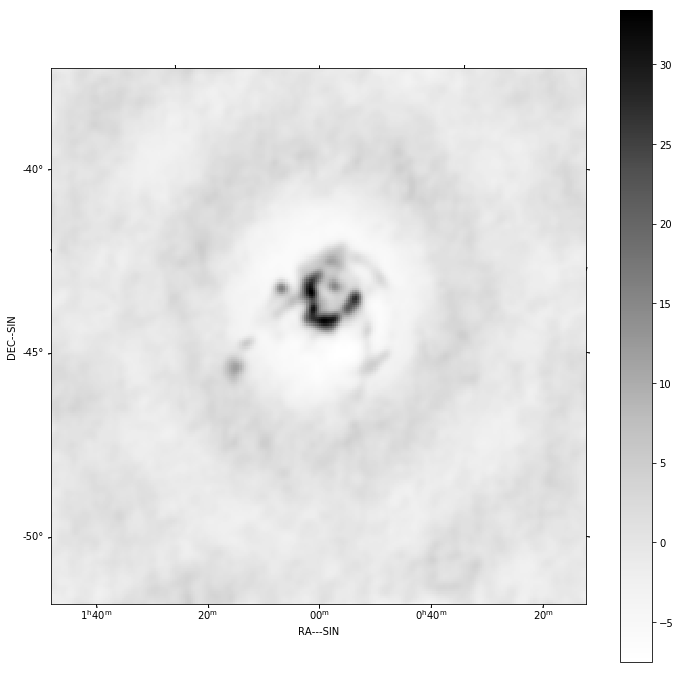

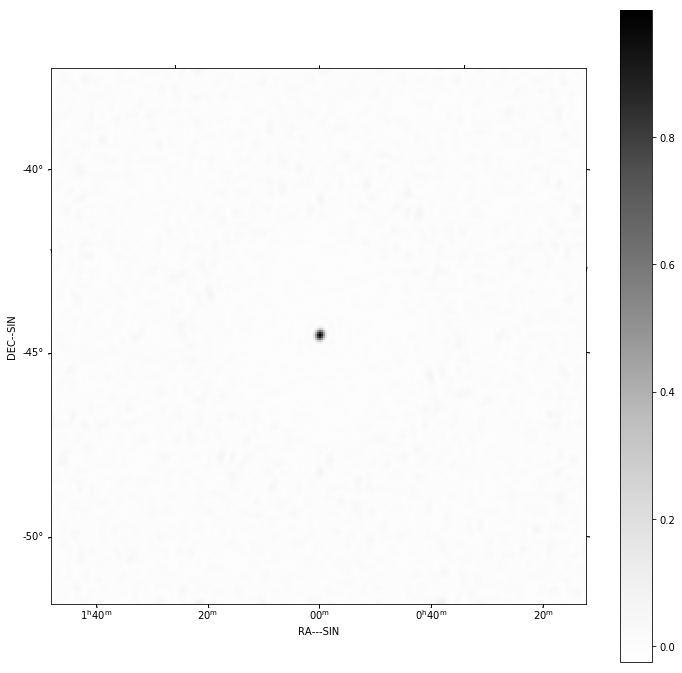

In [15]:
model = create_image_from_visibility(vt, cellsize=0.001, npixel=256)
dirty, sumwt = invert_list_mpi_workflow([vt], [model], context='2d')[0]
psf, sumwt = invert_list_mpi_workflow([vt], [model], context='2d', dopsf=True)[0]

show_image(dirty)
show_image(psf)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

In [18]:
result=deconvolve_list_mpi_workflow([(dirty,sumwt)], [(psf,sumwt)], [model])

threshold_list: using refchan 0 , sub_image 0, peak = 33.418636,
threshold_list : Global peak = 33.418636, sub-image clean threshold will be 3.341864
deconvolve_cube facet 0: PSF support = +/- 128 pixels
deconvolve_cube facet 0: PSF shape (1, 1, 256, 256)
deconvolve_cube facet 0: Multi-scale clean of each polarisation and channel separately
deconvolve_cube facet 0: Processing pol 0, channel 0
msclean facet 0: Peak of PSF = 0.9992088831836738 at (128, 128)
msclean facet 0: Peak of Dirty = 33.418636 Jy/beam at (148, 124) 
msclean facet 0: Coupling matrix =
 [[1.         0.96508872 0.59971887 0.12718816]
 [0.96508872 0.93218613 0.58573945 0.12654143]
 [0.59971887 0.58573945 0.42406774 0.11731114]
 [0.12718816 0.12654143 0.11731114 0.06923701]]
msclean facet 0: Max abs in dirty Image = 33.445095 Jy/beam
msclean facet 0: Start of minor cycle
msclean facet 0: This minor cycle will stop at 100 iterations or peak < 3.341864 (Jy/beam)
msclean facet 0: Timing for setup: 0.158 (s) for dirty shape

deconvolve_cube : Cleaning inner quarter of each sky plane
deconvolve_cube : PSF support = +/- 128 pixels
deconvolve_cube : PSF shape (1, 1, 256, 256)
deconvolve_cube : Multi-scale clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
msclean : Peak of PSF = 0.9992088831836738 at (128, 128)
msclean : Peak of Dirty = 33.418636 Jy/beam at (148, 124) 
msclean : Coupling matrix =
 [[1.         0.96508872 0.59971887 0.12718816]
 [0.96508872 0.93218613 0.58573945 0.12654143]
 [0.59971887 0.58573945 0.42406774 0.11731114]
 [0.12718816 0.12654143 0.11731114 0.06923701]]
msclean : Max abs in dirty Image = 33.445095 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 1000 iterations or peak < 0.334451 (Jy/beam)
msclean : Timing for setup: 0.219 (s) for dirty shape (256, 256), PSF shape (256, 256) , scales [0, 3, 10, 30]
msclean : Minor cycle 0, peak [23.04812494 23.11827695 23.66695334 17.98439773] at [137, 128, 3]
msclean : Mi

Text(0.5,1,'Restored')

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


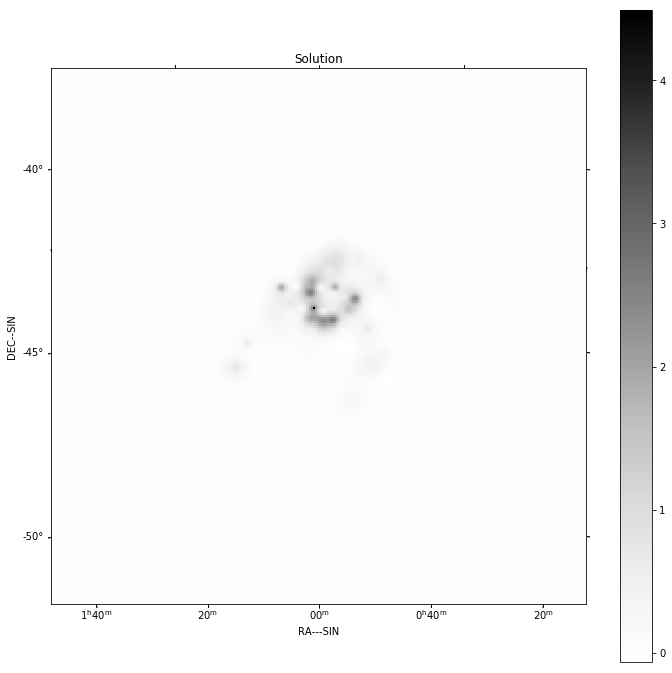

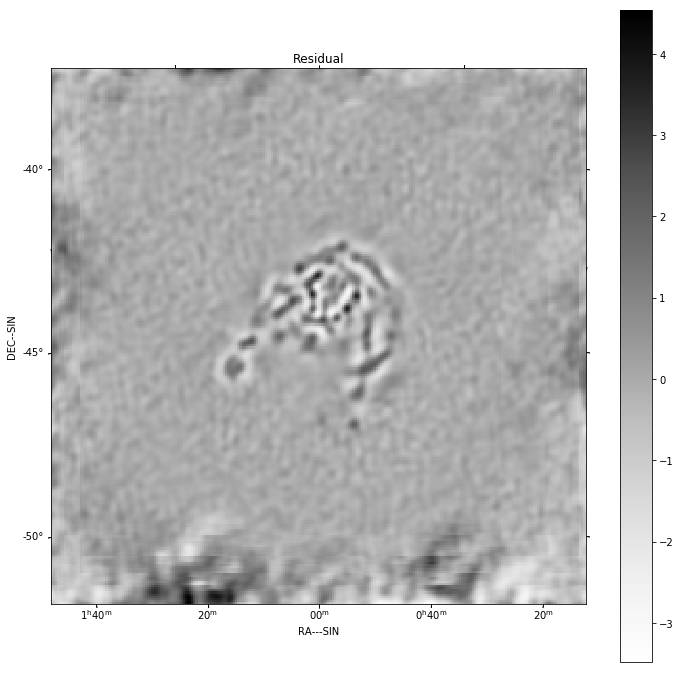

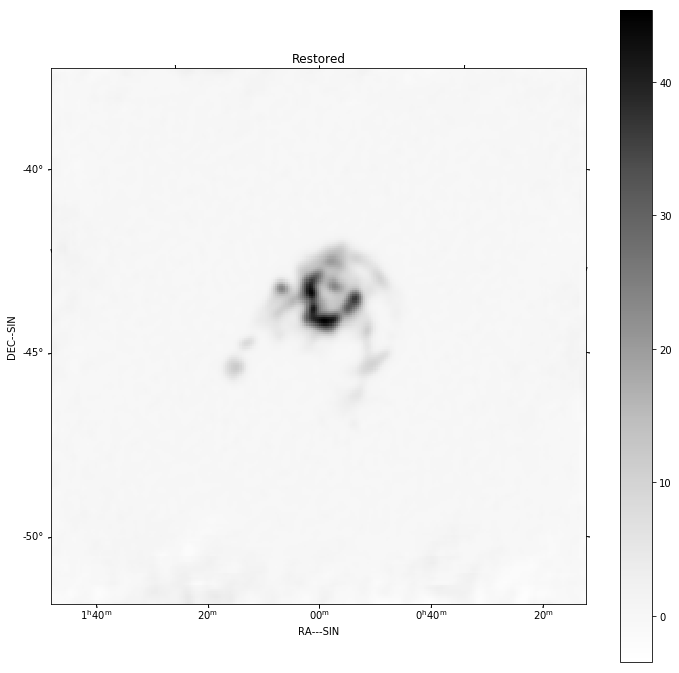

In [16]:
comp, residual = deconvolve_cube(dirty, psf, niter=1000, threshold=0.001, fracthresh=0.01, window_shape='quarter',
                                 gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

In [ ]:
vtmodel = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_list_serial_workflow([vtmodel], [comp], context='2d')[0]

Now we will plot the original visibility and the residual visibility.

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]-vtmodel.data['vis'][:]), '.', color='r', 
         label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()
